In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
sns.set()
%matplotlib inline

In [200]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.models import LinearColorMapper, ColorBar, BasicTicker

In [6]:
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))
# pd.set_option('display.float_format',lambda x: '%.4f' % x)

The [Chicago Historical temperature data came from NOAA](https://www.ncdc.noaa.gov/cdo-web/datasets). I pulled in data from 4 separate weather stations around Chicago. Chicago is not large enough that there will be massive monthly temperature differences between different weather stations in the city, and all weather stations in the NOAA database are reputable (ie calibrate their instruments, so same-year comparisons should have the same accuracy, and measurements shouldn't be off by more than 1 degree F.

In [7]:
CSV_PATH = os.path.join('data', 'weather', 'chicago_hist.csv')
chi = pd.read_csv(CSV_PATH, encoding='latin1', parse_dates=['DATE']) 
chi.head()

,STATION,NAME,DATE,CDSD,DSND,DSNW,EMNT,EMSD,EMSN,EMXP,EMXT,HDSD,PRCP,SNOW,TAVG,TMAX,TMIN
0,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-03-01,NaN,1.0,2.0,8.0,1.0,4.2,0.36,77.0,NaN,1.39,6.0,36.2,44.8,27.5
1,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-04-01,NaN,0.0,0.0,21.0,0.0,0.6,0.90,74.0,NaN,2.01,0.7,44.0,53.7,34.2
2,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-05-01,NaN,0.0,0.0,31.0,0.0,0.0,0.76,89.0,NaN,1.69,0.0,58.2,70.1,46.2
3,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-06-01,NaN,0.0,0.0,41.0,0.0,0.0,2.56,87.0,NaN,6.64,0.0,63.0,72.9,53.0
4,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-11-01,NaN,0.0,0.0,19.0,0.0,0.1,1.29,68.0,NaN,4.06,0.1,40.6,47.2,33.9


In [8]:
temp_chi = chi[['DATE', 'TAVG', 'NAME']]
temp_chi.head()

,DATE,TAVG,NAME
0,1928-03-01,36.2,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"
1,1928-04-01,44.0,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"
2,1928-05-01,58.2,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"
3,1928-06-01,63.0,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"
4,1928-11-01,40.6,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"


In [9]:
temp_chi = temp_chi.pivot(index='DATE', columns='NAME')
temp_chi.head()

TAVG                            \
NAME       CHICAGO MIDWAY AIRPORT 3 SW, IL US CHICAGO UNIVERSITY, IL US   
DATE                                                                      
1893-11-01                                NaN                       NaN   
1893-12-01                                NaN                       NaN   
1894-01-01                                NaN                       NaN   
1894-02-01                                NaN                       NaN   
1894-03-01                                NaN                       NaN   

                                                               
NAME       CHICAGO WEATHER BUREAU CITY 2, IL US JOLIET, IL US  
DATE                                                           
1893-11-01                                  NaN          37.9  
1893-12-01                                  NaN          28.5  
1894-01-01                                  NaN          30.7  
1894-02-01                                  NaN          24.7  
1894-03-01                                  NaN          45.6

In [10]:
temp_chi = pd.DataFrame(temp_chi.mean(axis=1))
temp_chi.columns = ['Avg_Temp']

In [11]:
temp_chi.head()

,Avg_Temp
DATE,
1893-11-01,37.9
1893-12-01,28.5
1894-01-01,30.7
1894-02-01,24.7
1894-03-01,45.6


**Now that we have a continuous series of Chicago temperature data, we can plot that data and look for trends.** 

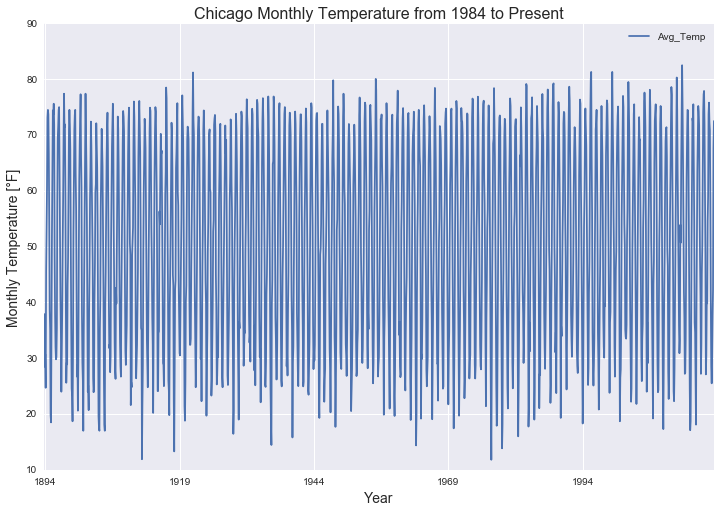

In [12]:
ax = temp_chi.plot(figsize=(12,8))
ax.set_title('Chicago Monthly Temperature from 1984 to Present', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Monthly Temperature [°F]', fontsize=14)

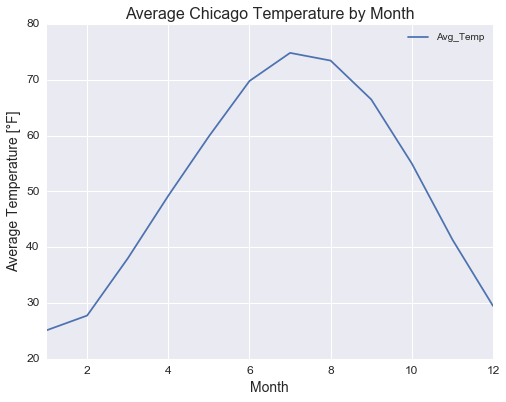

In [13]:
chi_temp_by_month = temp_chi.groupby(temp_chi.index.month).mean()
ax = chi_temp_by_month.plot(fontsize=12, figsize=(8,6))
ax.set_title('Average Chicago Temperature by Month', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Average Temperature [°F]', fontsize=14)

**Our data is monthly, and as you can see from the two plots below, the average monthly temperature cycles every year. This is what we expect, but all that variation makes it hard to determine if any significant trends are present. To We'll decompose our temperature data into 3 separate time-series; trend, seasonality, and residual noise. **

In [14]:
def decomposition_to_df(decomp):
    """Helper Method that makes a DataFrame from decomposition data.
    Args: 
        decomp:   the DecomposeResult returned from statsmodels
                seasonal_decompose() method.
    Returns:
        A pandas dataframe containing 3 series."""
    trend = decomp.trend
    trend.columns = ['Trend']
    seasonality = decomp.seasonal
    seasonality.columns = ['Seasonality']
    residuals = decomp.resid
    residuals.columns = ['Residuals']
    return trend.join(seasonality).join(residuals)

In [15]:
decomposition = sm.tsa.seasonal_decompose(temp_chi)
decomposed = decomposition_to_df(decomposition)

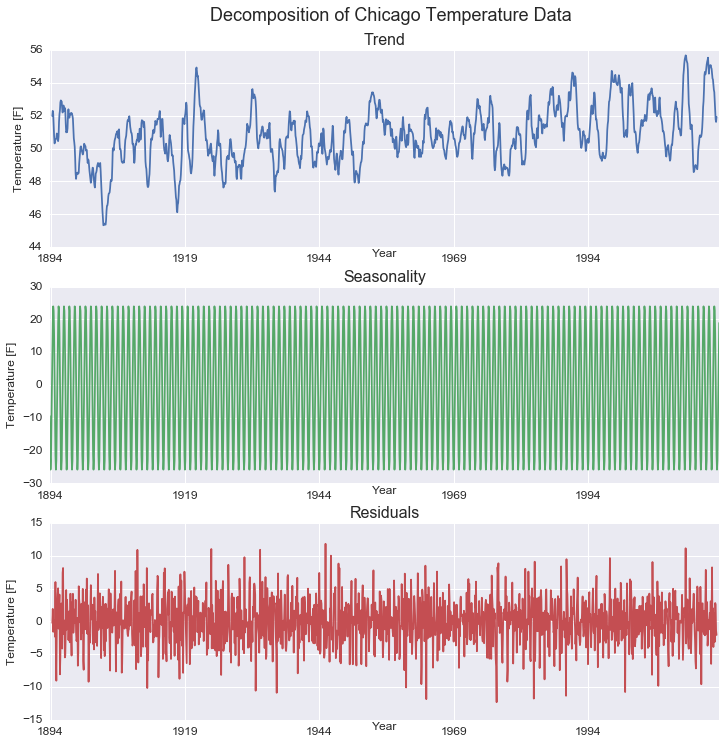

In [16]:
ax = decomposed.plot(subplots=True,
                     figsize=(12, 12), 
                     fontsize=12, 
                     sharey=False, 
                     sharex=False, 
                     legend=False)

for i in range(len(decomposed.columns.values)):
    ax[i].set_title(decomposed.columns.values[i], fontsize=16)
    ax[i].set_ylabel('Temperature [F]', fontsize=12)
    ax[i].set_xlabel('Year', fontsize=12)
    ax[i].xaxis.set_label_coords(0.5, -0.01)
    
# ax[2].xaxis.set_label_coords(0.5, -0.1)
    
plt.suptitle('Decomposition of Chicago Temperature Data', x=.52, y=0.95, fontsize=18)
plt.show()

In [17]:
print('Seasonality max value: {:2.2f}°F'.format(decomposed['Seasonality'].max()))
print('Seasonality min value: {:2.2f}°F'.format(decomposed['Seasonality'].min()))
print('Average Trend value from 1895 to 1920: {:2.2f}°F'
      .format(decomposed.loc['1895':'1920', 'Trend'].mean()))
print('Average Trend value from 1930 to 1970: {:2.2f}°F'
      .format(decomposed.loc['1940':'1960', 'Trend'].mean()))
print('Average Trend value from 1980 to 2018: {:2.2f}°F'
      .format(decomposed.loc['1980':'2018', 'Trend'].mean()))

Seasonality max value: 23.97°F
Seasonality min value: -25.78°F
Average Trend value from 1895 to 1920: 49.94°F
Average Trend value from 1930 to 1970: 50.60°F
Average Trend value from 1980 to 2018: 51.92°F


**Looking at the plots of the parts of the decomposed temperature data, we can quickly see several things:**
* the seasonality component is extremely consistent and swings between about 24 °F and -26 °F.
* the level of residual noise is fairly consistent over the entire span, (which is good as we expect the noise to be random and not vary with time).
* the center of the trend line slowly trends up from around 50.0 °F aroun 1900, to around 50.6 °F in the middle of the century to around 51.9 °F  over the past ~40 years. 

# What's causing this temperature increase?

To better understand the rising air temperatures, we have to look at the composition of air, how these air components affect the air temperature, and how the composition of air changes over time. 

## What is our atmosphere made of? 

### Dry Air Composition

The table below shows [the molar mass, the volume percentage, and total mass for the 16 most common dry air components](https://www.atmos.washington.edu/~dennis/321/Chapter_01_Tables.pdf), and I've plotted those relative composition values below. From this plot, you can quickly see that air composition is dominated by $\text{N}_2$ (78.08%), $\text{O}_2$ (20.95%), and $\text{Ar}$ (0.934%), with **all other components making up the remaining 0.036% (!) of the dry air in the atmosphere.** If the air composition matters to air temperature, we should take a close look at the major players.   

#### Why dry? What about H2O?
Also, I should note that we specify **Dry** air composition as the amount of $\text{H}_2\text{O}$ (water) in the air depends on where you are. The percent of $\text{H}_2\text{O}$ varies between 0% and 5% of the air (by volume) depending on the measurement location's temperature, recent precipitation, and proximity to bodies of water. When the temperature is at or below 32 °F, the percentage of $\text{H}_2\text{O}$ in the air drops down to 0%, and when the temperature increases, the $\text{H}_2\text{O}$ percentage increases. As the percentage increase of $\text{H}_2\text{O}$ in the air is a result of increasing temperatures, we can rule out $\text{H}_2\text{O}$ as a cause of increasing temperatures. 

In [118]:
CSV_PATH = os.path.join('data', 'weather', 'air_comp_washington.csv')
air_comp = pd.read_csv(CSV_PATH, header=1, index_col='Formula')
dry_air_comp = air_comp[~air_comp.index.isin(['H2O', 'Dry', 'O3'])]

In [119]:
for row in zip(dry_air_comp.index.values,dry_air_comp['pct_vol']):
    tokens = row[1].split()
    if len(tokens) == 1:
        dry_air_comp.loc[row[0],'pct_vol'] = float(tokens[0])
    elif tokens[1] == 'ppmv':
        dry_air_comp.loc[row[0],'pct_vol'] = float(tokens[0]) * 10e-5
    elif tokens[1] == 'ppbv':
        dry_air_comp.loc[row[0],'pct_vol'] = float(tokens[0]) * 10e-8
    elif tokens[1] == 'pptv':
        dry_air_comp.loc[row[0],'pct_vol'] = float(tokens[0]) * 10e-11

C:\Users\mattt\Anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [120]:
dry_air_comp

,Name,Molar_Mass,pct_vol,Total_Mass_g
Formula,,,,
N2,Nitrogen,28.013,78.08,3870000000000000000000
O2,Oxygen,31.999,20.95,1185000000000000000000
Ar,Argon,39.948,0.934,65900000000000000000
CO2,Carbon dioxide,44.010,0.0353,2760000000000000000
Ne,Neon,20.183,0.001818,64800000000000000
Kr,Krypton,83.800,0.000114,16900000000000000
He,Helium,4.003,0.000524,3710000000000000
CH4,Methane,16.043,0.000172,4900000000000000
Xe,Xenon,131.300,8.7e-06,2020000000000000


$\text{N}_2$, $\text{O}_2$, and $\text{Ar}$ make up 99.964% of the volume of all dry air on earth. 

In [188]:
diff = 407 - 340
1000000*.7808 / (1000000+diff)
# 1000000*.00934 / (1000000+diff)


0.7807476899047764

In [127]:
dry_air_comp.loc[['N2','O2','Ar'],'pct_vol'].sum()

99.964

In [123]:
# Just over 100%. I'll attribute this to unstated rounding error
dry_air_comp['pct_vol'].sum()

100.00203984000001

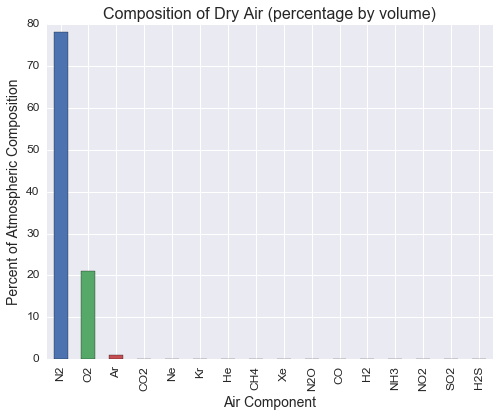

In [124]:
ax = dry_air_comp['pct_vol'].plot(kind='bar', figsize=(8,6))
ax.set_ylabel('Percent of Atmospheric Composition', fontsize=14)
ax.set_xlabel('Air Component', fontsize=14)
ax.set_title('Composition of Dry Air (percentage by volume)', fontsize=16)
ax.tick_params(labelsize=12)

Looking at the minor components of air (ie total composition without $\text{N}_2$, $\text{O}_2$, and $\text{Ar}$), we see that $\text{CO}_2$ is the dominant remaining gas.  

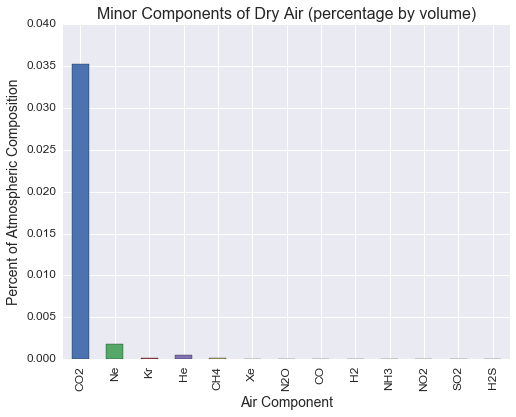

In [125]:
ax = dry_air_comp.loc['CO2':,'pct_vol'].plot(kind='bar', figsize=(8,6))
ax.set_ylabel('Percent of Atmospheric Composition', fontsize=14)
ax.set_xlabel('Air Component', fontsize=14)
ax.set_title('Minor Components of Dry Air (percentage by volume)', fontsize=16)
ax.tick_params(labelsize=12)

### Rising $\text{CO}_2$ Levels
This data was from 1990. The values for mono-atomic components (eg $\text{N}_2$, $\text{O}_2$, and $\text{Ar}$) are still accurate as the supply of these elements on Earth is constant and no massive-scale chemical reactions are changing $\text{N}_2$, $\text{O}_2$, or $\text{Ar}$ into new compounds, but as the plot of (global monthly $ \text{CO}_2$ measurements)[https://www.esrl.noaa.gov/gmd/ccgg/trends/global.html#global] below shows, the measured concentration of $\text{CO}_2$ has been steadily increasing from 340 parts per million (ppm) in 1980 to 407 ppm today. While that difference changes the percents of $\text{N}_2$, $\text{O}_2$, and $\text{Ar}$ by less than 0.01%, **it's a 20% increase in the amount of $\text{CO}_2$ in the air, in just 40 years!**

In [182]:
TXT_PATH = os.path.join('data', 'weather', 'mlo', 'co2_mm_gl.txt')
names = ['year','month','decimal','average','trend']
global_co2 = pd.read_table(TXT_PATH,
                        header=None, 
                        skiprows=58,
                        delim_whitespace=True)
global_co2.columns = names
global_co2[['year','month']] = global_co2[['year','month']].astype(str)
global_co2['date'] = global_co2['year'] + '-' + global_co2['month']
global_co2['date'] = pd.to_datetime(global_co2['date'])
global_co2.set_index('date', inplace=True)
global_co2.drop(['year','month', 'decimal'], axis=1, inplace=True)
# global_co2.head()

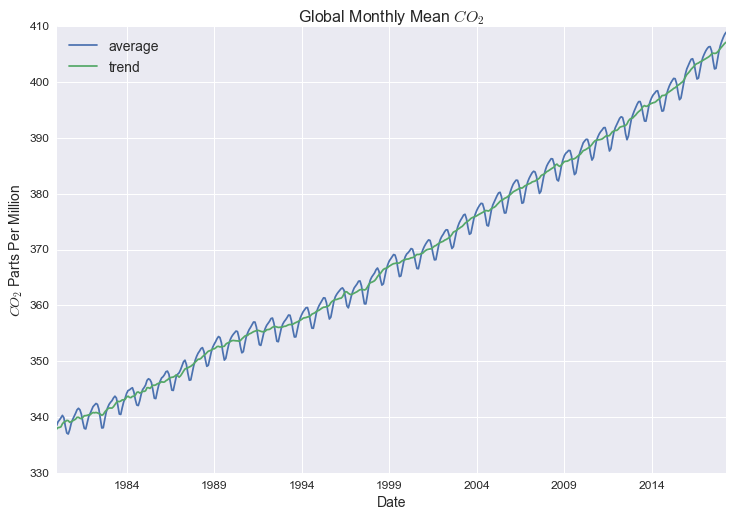

In [181]:
ax = global_co2.plot(figsize=(12,8), fontsize=12)
ax.set_title('Global Monthly Mean ${CO}_2$', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('$CO_2$ Parts Per Million', fontsize=14)
ax.legend(fontsize=14, loc='best')

## TODO: pick up from here. Maybe implement a Bokeh stacked area plot?

## What could be causing the $\text{CO}_2$ level to rise?

As I mentioned above, excluding nuclear reactions, chemical reactions are the only way to change the concentrations of atmospheric gases. The main chemical reaction that produces $\text{CO}_2$ is the combustion reaction, in which fuel (like wood, gasoline, alcohol, coal, or any other hydrocarbon) and oxygen react and release a lot of energy. Hydrocarbon combustion reactions will always have the form below

$$\text{C}_x\text{H}_y + z\text{O}_2 \longrightarrow x\text{CO}_2 + \frac{y}{2}\text{H}_2\text{O}$$
where $\text{C}_x\text{H}_y$ is the general form for any hydrocarbon. For example, gasoline is $\text{C}_8\text{H}_18$

https://www.engineeringtoolbox.com/co2-emission-fuels-d_1085.html

http://vaclavsmil.com/2016/12/14/energy-transitions-global-and-national-perspectives-second-expanded-and-updated-edition/  (data prior to 1965)
http://www.bp.com/statisticalreview (data from 1965 and beyond)

In [242]:
CSV_PATH = os.path.join('data', 'weather', 'global-primary-energy.csv')
energy_sources = pd.read_csv(CSV_PATH, encoding='latin1', parse_dates=['Year']) 
# energy_sources = pd.read_csv(CSV_PATH, encoding='latin1', parse_dates=['Year'], index_col='Year') 
energy_sources.columns = [x.replace(' (terawatt-hours)','') for x in energy_sources.columns]
energy_sources.drop(['Entity', 'Code'], axis=1, inplace=True)
energy_sources.head()

,Year,Coal,Solar,Crude_oil,Natural_gas,Traditional_biofuels,Other_renewables,Hydropower,Nuclear,Wind
0,1800-01-01,97.22230,0.0,0.0,0.0,5555.555556,0.0,0.0,0.0,0.0
1,1810-01-01,127.77788,0.0,0.0,0.0,5833.333333,0.0,0.0,0.0,0.0
2,1820-01-01,152.77790,0.0,0.0,0.0,6111.111111,0.0,0.0,0.0,0.0
3,1830-01-01,263.88910,0.0,0.0,0.0,6388.888889,0.0,0.0,0.0,0.0
4,1840-01-01,355.55584,0.0,0.0,0.0,6944.444444,0.0,0.0,0.0,0.0


In [238]:
def stacked(df):
    df_top = df.cumsum(axis=1)
    df_bottom = df_top.shift(axis=1).fillna({'y0': 0})[::-1]
    df_stack = pd.concat([df_bottom, df_top], ignore_index=True)
    return df_stack

from bokeh.palettes import brewer

def stacked_area(df, **kwargs):
    """Return a stacked area plot."""
    columns = df.columns
    series_noun = df.columns
    areas = stacked(df)
    x2 = np.hstack((df.index[::-1], df.index))

    p = figure(
        width=900, height=600, tools=[
            HoverTool(tooltips=[('Coal', "@Coal"), 
                                ('Solar', '@Solar'), 
                                ('Crude oil', '@Crude_oil'), 
                                ('Natural Gas', '@Natural_gas'), 
                                ('Traditional Biofuels', '@Traditional_biofuels'), 
                                ('Other Renewables', '@Other_renewables'),
                                ('Hydropower', '@Hydropower'), 
                                ('Nuclear', '@Nuclear'), 
                                ('Wind', '@Wind')])
        ],
        **kwargs
    )
    p.grid.minor_grid_line_color = '#eeeeee'

    ys = []
    xs = []
    names = []

    for col in columns:
        ys.append(areas[col])
        xs.append(x2)
        names.append(col)

    source = ColumnDataSource(data=dict(
        x=xs,
        y=ys,
        name=names,
    ))

    p.patches(
        'x', 'y', source=source, color=brewer['Spectral'][areas.shape[1]]
    )
    p.xaxis.formatter = DatetimeTickFormatter(
        formats=dict(days=["%a\n%d %b"])
    )
    return p

In [239]:
energy_sources.columns

Index(['Coal', 'Solar', 'Crude_oil', 'Natural_gas', 'Traditional_biofuels',
       'Other_renewables', 'Hydropower', 'Nuclear', 'Wind'],
      dtype='object')

In [241]:
areas

,Coal,Solar,Crude oil,Natural gas,Traditional biofuels,Other renewables,Hydropower,Nuclear,Wind
0,NaN,43403.142830,43736.195323,95120.415533,132384.586723,143387.802523,143949.468587,147972.406356,150588.946863
1,NaN,44015.530330,44271.721259,94757.048189,131353.707009,142464.818119,143001.229065,146904.511029,149479.768100
2,NaN,45233.992180,45430.325167,94913.968858,130652.799408,141872.863827,142369.378754,146255.436374,148796.679510
3,NaN,45205.498280,45343.059434,94431.565354,129953.829154,141283.915254,141742.658196,145539.854175,148031.803995
4,NaN,44395.062240,44495.096147,93064.122617,128076.395807,139517.582437,139944.804923,143622.100042,146093.622097
5,NaN,44277.591120,44342.286232,92324.566232,126357.651322,137911.027922,138309.583310,141811.231852,144463.389419
6,NaN,42282.467300,42316.283554,89829.741464,123257.238244,134923.904914,135300.401547,138741.656886,141507.790671
7,NaN,40427.431150,40448.349069,86452.593789,117568.948939,129316.385599,129653.355988,132909.025335,135620.976065
8,NaN,41035.159780,41047.751011,87862.007510,119821.433620,131650.199450,131963.706950,135230.757068,137968.616345
9,NaN,40474.289930,40481.992043,87489.630063,118635.795353,130546.453413,130841.588237,133925.319975,136671.801050


In [240]:
# areas = stacked(energy_sources)
stacked_area(energy_sources)

RuntimeError: 
Supplying a user-defined data source AND iterable values to glyph methods is
not possibe. Either:

Pass all data directly as literals:

    p.circe(x=a_list, y=an_array, ...)

Or, put all data in a ColumnDataSource and pass column names:

    source = ColumnDataSource(data=dict(x=a_list, y=an_array))
    p.circe(x='x', y='y', source=source, ...)



In [225]:
colors = brewer['Spectral'][areas.shape[1]]
x2 = np.hstack((df.index[::-1], df.index))

p = figure()
p.grid.minor_grid_line_color = '#eeeeee'

p.patches([x2] * areas.shape[1], [areas[c].values for c in areas],
          color=colors, alpha=0.8, line_color=None)

output_notebook()

show(p)

Loading BokehJS ...

In [208]:
cdf = ColumnDataSource(energy_sources)
p = figure(plot_height=500, plot_width=500, tools="", toolbar_location=None,
           title="Female Imprisonment Rates vs Male Imprisonment Rates in {}"
           .format(yr))
p.background_fill_color="#f5f5f5"
p.grid.grid_line_color="white"
p.xaxis.axis_label = 'Male Imprisonment Rate [per 100k State male pop.]'
p.yaxis.axis_label = 'Female Imprisonment Rate [per 100k State female pop.]'
p.scatter(x='Male_rate',
          y='Female_rate',
          source=cdf,
          fill_alpha=0.6,
          size=12,
          line_color=None)

p.add_tools(HoverTool(
    tooltips=[
        ('State', '@Code'),
        ('Male Rate', '@Male_rate'),
        ('Female Rate', '@Female_rate'),
    ],
))

output_notebook()
show(p)



In [216]:
df = pd.DataFrame(np.random.randint(10, 100, size=(20, 10))).add_prefix('y')
df

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9
0,30,60,55,85,10,46,63,31,11,97
1,32,92,13,55,26,24,81,40,59,12
2,32,44,19,93,97,93,23,37,41,52
3,79,60,83,64,20,88,97,21,32,16
4,33,62,18,18,48,37,22,10,68,79
5,48,27,77,42,34,96,40,70,88,74
6,47,61,25,43,75,53,89,27,92,13
7,45,88,63,56,66,15,85,62,22,66
8,66,65,35,41,93,42,77,50,45,18
9,54,95,44,12,67,40,72,74,52,23


In [206]:
# https://www.engineeringtoolbox.com/co2-emission-fuels-d_1085.html
CSV_PATH = os.path.join('data', 'weather', 'specific_co2.csv')
specific_co2 = pd.read_csv(CSV_PATH, encoding='latin1', header=[0,1])
# specific_co2.drop()
specific_co2

Fuel liq_dens spec_c_cont    spec_en             \
                   units     kg/l  kgC/kgfuel kWh/kgfuel Btu/lbfuel   
0   Methane(natural gas)      NaN        0.75       15.4    23900.0   
1                Propane    0.510        0.82       13.8    21300.0   
2                 Butane    0.564        0.83       13.6    21100.0   
3                    LPG    0.537        0.82       13.7    21200.0   
4               Gasoline    0.737        0.90       12.9    19900.0   
5         Kerosene (Jet)    0.821        0.82       12.0    18500.0   
6                 Diesel    0.846        0.86       12.7    19605.0   
7         Heavy fuel oil    0.980        0.85       11.6    18000.0   
8         Petroleum coke      NaN        0.89        9.4    14500.0   
9                  Coal:      NaN         NaN        NaN        NaN   
10            Anthracite      NaN        0.92        9.0    14000.0   
11            Bituminous      NaN        0.65        8.4    13000.0   
12         Subbituminous      NaN        0.40        6.8    10500.0   
13               Lignite      NaN        0.30        3.9     6000.0   
14                  Coke      NaN        0.77        7.2    11200.0   
15                  Peat      NaN        0.52        4.7     7300.0   
16          Ethanol fuel    0.789        0.52        8.3    12800.0   
17         Methanol fuel    0.791        0.37        5.5     8500.0   
18             Biodiesel    0.880        0.78       11.3    17400.0   
19                  Wood      NaN        0.50        4.5     7000.0   

    spec_CO2_em                                                                
   KgCO2/kgfuel KgCO2/galfuel lbCO2/galfuel kgCO2/kWh kgCO2/GJ lbCO2/mill Btu  
0          2.75           NaN           NaN      0.18   49.600          115.0  
1          2.99          5.78          12.7      0.22   60.400          140.0  
2          3.03          6.47          14.3      0.22   61.700          144.0  
3          3.01          6.12          13.5      0.22   61.000          142.0  
4          3.30          9.20          20.3      0.26    0.071          165.3  
5          3.00          9.33          20.6      0.25    0.070          162.5  
6          3.15         10.10          22.3      0.25    0.069          160.8  
7          3.11         11.60          25.5      0.27    0.075          173.3  
8          3.26         14.70          32.4      0.35    0.097          225.1  
9           NaN           NaN           NaN       NaN    0.000          227.3  
10         3.37           NaN           NaN      0.37    0.104          229.5  
11         2.38           NaN           NaN      0.28    0.079          231.7  
12         1.47           NaN           NaN      0.22    0.060          233.9  
13         1.10           NaN           NaN      0.28    0.079          236.1  
14         2.82           NaN           NaN      0.39    0.108          251.5  
15         1.91           NaN           NaN      0.40    0.112          260.7  
16         1.91          5.71          12.6      0.23    0.064          149.6  
17         1.37          4.11           9.1      0.25    0.070          162.2  
18         2.85          9.48          20.9      0.25    0.070          162.8  
19         1.83           NaN           NaN      0.41    0.113          263.1

In [199]:
specific_co2.columns

Index(['Fuel', 'liq_dens_kg/l', 'spec_c_cont_kgC/kgfuel', 'spec_en_kWh/kgfuel',
       'spec_en_Btu/lbfuel', 'spec_CO2em_KgCO2/kgfuel',
       'spec_CO2em_KgCO2/galfuel', 'spec_CO2em_lbCO2/galfuel',
       'spec_CO2em_kgCO2/kWh', 'spec_CO2em_kgCO2/GJ',
       'spec_CO2em_lbCO2/mill_Btu'],
      dtype='object')

In [18]:
TXT_PATH = os.path.join('data', 'weather', 'nasa_msis_atmosphere_composition_data_12_08.txt')
names = ['Height [km]', 'O, cm-3', 'N2, cm-3', 'O2, cm-3', 'Mass Density', 
         'Temperature_neutral', 'Temperature_exospheric', 'He, cm-3',
         'Ar, cm-3', 'H, cm-3','N, cm-3', 'F10_7_daily']
atmos_comp = pd.read_table(TXT_PATH, 
                           header=None, 
                           skiprows=39,
                           delim_whitespace=True)

atmos_comp.columns = names
atmos_comp.drop(['Temperature_neutral', 'Temperature_exospheric', 'Mass Density', 'F10_7_daily'], axis=1, inplace=True)
atmos_comp.set_index('Height [km]', inplace=True)
atmos_comp.head()

,"O, cm-3","N2, cm-3","O2, cm-3","He, cm-3","Ar, cm-3","H, cm-3","N, cm-3"
Height [km],,,,,,,
0.0,0.0,2.053000e+19,5.508000e+18,1.378000e+14,2.456000e+17,0.0,0.0
1.0,0.0,1.839000e+19,4.932000e+18,1.234000e+14,2.199000e+17,0.0,0.0
2.0,0.0,1.655000e+19,4.440000e+18,1.111000e+14,1.980000e+17,0.0,0.0
3.0,0.0,1.494000e+19,4.008000e+18,1.003000e+14,1.787000e+17,0.0,0.0
4.0,0.0,1.349000e+19,3.619000e+18,9.053000e+13,1.614000e+17,0.0,0.0


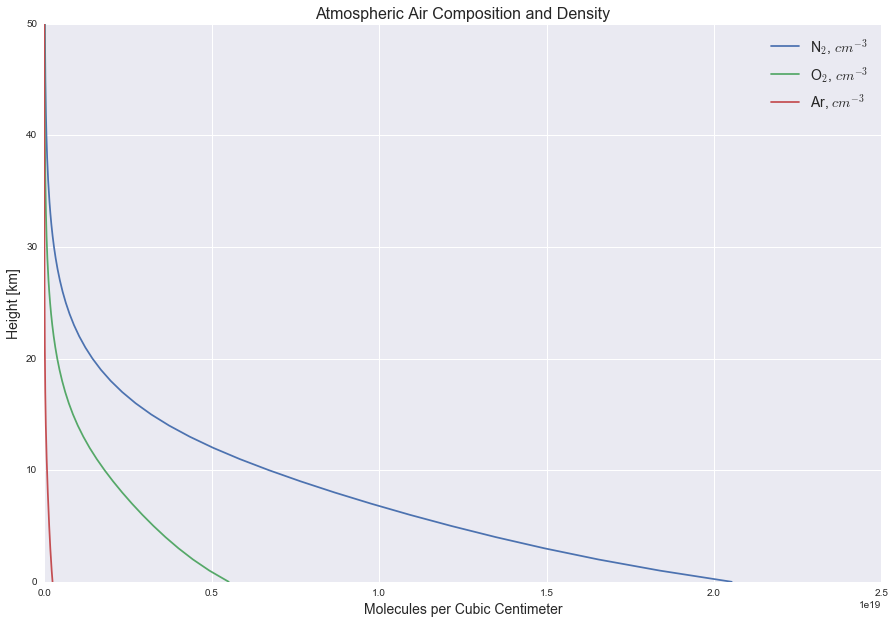

In [193]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
# ax.plot(atmos_comp['O, cm-3'].values, atmos_comp['O, cm-3'].index, label='O, $cm^{-3}$')
ax.plot(atmos_comp['N2, cm-3'].values, atmos_comp['N2, cm-3'].index, label='N$_2$, $cm^{-3}$')
ax.plot(atmos_comp['O2, cm-3'].values, atmos_comp['O2, cm-3'].index, label='O$_2$, $cm^{-3}$')
# ax.plot(atmos_comp['He, cm-3'].values, atmos_comp['He, cm-3'].index, label='He, $cm^{-3}$')
ax.plot(atmos_comp['Ar, cm-3'].values, atmos_comp['Ar, cm-3'].index, label='Ar, $cm^{-3}$')
# ax.plot(atmos_comp['H, cm-3'].values, atmos_comp['H, cm-3'].index, label='H, $cm^{-3}$')
# ax.plot(atmos_comp['N, cm-3'].values, atmos_comp['N, cm-3'].index, label='N, $cm^{-3}$')
ax.set(ylim=[0, 50])
ax.set_ylabel('Height [km]', fontsize=14)
ax.set_xlabel('Molecules per Cubic Centimeter', fontsize=14)
ax.set_title('Atmospheric Air Composition and Density', fontsize=16)
ax.legend(fontsize=14)
plt.show()

In [26]:
print('At a height of 0 km, N2 makes up {:2.6}% of the dry atmosphere at that height'
      .format(atmos_comp.loc[0,'N2, cm-3'] * 100 / (atmos_comp.loc[0,:].sum()+0.0407)))
print('At a height of 0 km, O2 makes up {:2.6}% of the dry atmosphere at that height'
      .format(atmos_comp.loc[0,'O2, cm-3'] * 100 / (atmos_comp.loc[0,:].sum()+0.0407)))
print('At a height of 0 km, Ar makes up {:2.6}% of the dry atmosphere at that height'
      .format(atmos_comp.loc[0,'Ar, cm-3'] * 100 / (atmos_comp.loc[0,:].sum()+0.0407)))
print('At a height of 0 km, He makes up {:2.6}% of the dry atmosphere at that height'
      .format(atmos_comp.loc[0,'He, cm-3'] * 100 / (atmos_comp.loc[0,:].sum()+0.0407)))

At a height of 0 km, N2 makes up 78.1091% of the dry atmosphere at that height
At a height of 0 km, O2 makes up 20.9559% of the dry atmosphere at that height
At a height of 0 km, Ar makes up 0.934418% of the dry atmosphere at that height
At a height of 0 km, He makes up 0.000524279% of the dry atmosphere at that height


ftp://aftp.cmdl.noaa.gov/data/greenhouse_gases/co2/in-situ/surface/

ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

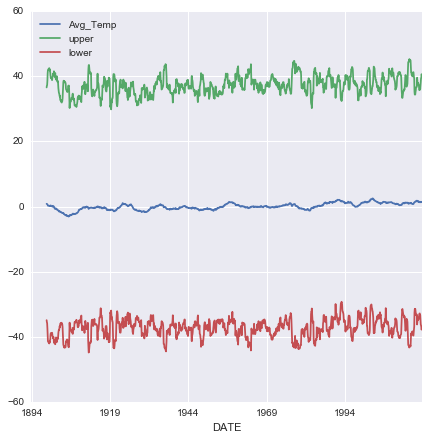

In [22]:
moving_avg = temp_chi.rolling(window=60).mean()
span_avg = moving_avg['Avg_Temp'].mean()
moving_avg = moving_avg - span_avg
moving_std = temp_chi.rolling(window=12).std()
moving_avg['upper'] = moving_avg['Avg_Temp'] + (2 * moving_std['Avg_Temp']) 
moving_avg['lower'] = moving_avg['Avg_Temp'] - (2 * moving_std['Avg_Temp'])
moving_avg.plot(figsize=(7,7))

In [23]:
# sns.lmplot(data=moving_avg,
#            x=moving_avg.index,
#            y='Avg_Temp')

In [24]:
ma = co2_levels.rolling(window=52).mean()
mstd = co2_levels.rolling(window=52).std()
ma['upper'] = ma['co2'] + (2 * mstd['co2'])
ma['lower'] = ma['co2'] - (2 * mstd['co2'])
ax = ma.plot(linewidth=0.8, fontsize=6, figsize=(8,6), color=['black', '#ca0020', '#0571b0'])

# Specify labels, legend, and show the plot
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('CO2 levels in Mauai Hawaii', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_title('Rolling mean and variance of CO2 levels\nin Mauai Hawaii from 1958 to 2001', fontsize=14)
ax.legend(fontsize=14, loc='best')
plt.show()

NameError: name 'co2_levels' is not defined